<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 10 (Extra): Stochastic Gradient Descent</h2>
<br>

This notebook is a demonstration of stochastic gradient descent with the Keras package.

<a href="#1.-Credit-card-fraud-data">Credit card fraud data</a> <br>
<a href="#2.-Feature-Engineering">Feature engineering</a> <br>
<a href="#3.-Neural-Network">Stochastic gradient descent</a> <br>
<a href="#7.-Model-validation">Model Validation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
from IPython.display import clear_output

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## 1. Credit card fraud data

We use the [credit card fraud dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) data available from [Kaggle Datasets](https://www.kaggle.com/datasets). Our objective is to predict which credit card transactions are fraud. Let's assume the following loss matrix: 

<table>
  <tr>
    <th>Actual/Predicted</th>
    <th>Legitimate</th>
     <th>Fraud</th>
  </tr>
  <tr>
    <th>Legitimate</th>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <th>Fraud</th>
    <td>50</td>
    <td>0</td>
  </tr>
</table>

That is, we assume that it is much worse for the financial institution to not catch a fraud than to flag a legitimate transaction as potential fraud.

We start as usual by loading and inspecting the data (the predictors are de-identified):

In [4]:
data = pd.read_csv('Data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset has 284,807 transactions:

In [5]:
print(data.shape)

(284807, 31)


Despite the large number of observations, only 492 transactions (0.17%) are fraud. Therefore this is a highly imbalance problem.

In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Because the number of frauds is small we only consider training and validation sets for this tutorial, without no test set.

In [7]:
response='Class'
index_train, index_val  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.8, random_state=1)

predictors = list(data.columns[1:-1])

X_train = data.loc[index_train, predictors].to_numpy()
y_train = data.loc[index_train, response].to_numpy()

X_val = data.loc[index_val, predictors].to_numpy()
y_val = data.loc[index_val, response].to_numpy()

## 2. Feature engineering

We standardise the predictors and perform a Yeo-Johnson transformation on all features. 

In [8]:
from sklearn.preprocessing import PowerTransformer

yj = PowerTransformer(method='yeo-johnson')
yj.fit(X_train)

X_train = yj.transform(X_train)
X_val = yj.transform(X_val)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

## 3. Stochastic gradient descent

This dataset represents only two days of transactions for the company that supplied the data. Therefore, in a real setting, we could be fitting a classifier for fraud detection on hundreds of millions of transactions. With such large data, we often turn to stochastic gradient descent (SGD) for optimisation due to the high computational cost of calculating the gradient for the entire training data.

Even though scikit-learn has an implementation of SGD, the [Keras](https://keras.io/) package for deep learning is more popular for this purpose. You will study deep learning if you take QBUS6850 (Machine Learning in Business). Here, we exploit the fact that the logistic regression model is a special case of deep learning.

The next cell specifies the logistic regression model as a Keras model. 

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# Architecture
X = keras.Input(shape=(X_train.shape[1],))
y = layers.Dense(1, activation='sigmoid')(X)

# Build model
sgd = keras.Model(inputs=X, outputs=y)
sgd.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


We use the Adam algorithm for optimisation, which is an improved version of SGD that does not require much tuning

We commonly use a technique called early stopping when training a model by SGD. In early stopping, we keep track of the validation error at every epoch (or at every few epochs) and stop the optimisation algorithm if the validation error stops improving. Early stopping works as a regularisation technique, with effect similar to $\ell_2$ regularisation.

In [10]:
from tensorflow.keras.optimizers import Adam

# A callback is an object that implements actions at different stages of training (typically at every epoch)
# This callback will stop training when the validation error does not improve for 5 epochs
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)

# Optimisation
sgd.compile(loss='binary_crossentropy', optimizer=Adam(1e-2))
sgd.fit(X_train, 
        y_train, 
        epochs=50,
        batch_size=512, 
        validation_data =(X_val, y_val), 
        callbacks = [callback],
        verbose=0)

The training and validation errors stabilise after just a few epochs.

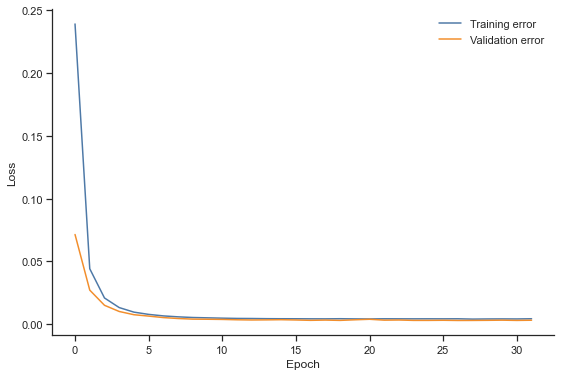

In [11]:
fig, ax= plt.subplots()
ax.plot(sgd.history.history['loss'], label='Training error')
ax.plot(sgd.history.history['val_loss'], label='Validation error')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
sns.despine()
plt.show()

## 4. Scikit-learn


In [12]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none')
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 5. Model Validation

We end up with two versions of the logistic regression model trained different optimisation algorithms. While we would need more fraud cases in the validation set to reach a firm conclusion, the early stopping in SGD may have led to an improvement in the risk (via higher sensitivity). Your numbers for SGD may be different due to the randomness in the method. 

In a real-world setting, small reductions in the risk can translate into significant reductions in financial losses due to fraud.

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss
from sklearn.metrics import confusion_matrix, log_loss, average_precision_score, f1_score

columns=['Relative risk', 'Error rate', 'Sensitivity', 'Specificity', 
         'Precision', 'Average Precision']
rows=['Logistic regression', 'Logistic regression (SGD)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, sgd]

lfp = 1
lfn = 50
tau = lfp/(lfp+lfn)

for i, method in enumerate(methods):
    
    if method in [sgd]:
        y_prob = method.predict(X_val)
    else:
        y_prob = method.predict_proba(X_val)[:,1]

    y_pred = (y_prob>tau).astype(int)
       
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    results.iloc[i,0]=  (fp*lfp+fn*lfn)/len(y_val)
    results.iloc[i,1]=  1 - accuracy_score(y_val, y_pred)
    results.iloc[i,2]=  tp/(tp+fn)
    results.iloc[i,3]=  tn/(tn+fp)
    results.iloc[i,4]=  precision_score(y_val, y_pred)
    results.iloc[i,5]=  average_precision_score(y_val, y_prob)

results.iloc[:,0] /= results.iat[0,0]
results.round(3)

,Relative risk,Error rate,Sensitivity,Specificity,Precision,Average Precision
Logistic regression,1.000,0.002,0.888,0.998,0.500,0.828
Logistic regression (SGD),0.867,0.001,0.898,0.999,0.629,0.823


### Additional Code

The two cells below format the notebook for display online. Please omit them from your work.

In [14]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [15]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')

FileNotFoundError: [Errno 2] No such file or directory: 'css\\jupyter.css'